In [67]:
import xarray as xr
import numpy as np
import plotly.express as px

In [66]:
def convert_longitude(lon_array):
    """
    Convert longitude values from 0-360° format to -180 to +180° format.
    
    Parameters:
    lon_array : numpy.ndarray
        Input longitude array with values between 0 and 360 degrees
        
    Returns:
    numpy.ndarray
        Converted longitude array with values between -180 and +180 degrees
    """
    # Make a copy to avoid modifying the original array
    lon_converted = np.copy(lon_array)
    
    # Find values greater than 180° and subtract 360° from them
    lon_converted = np.where(lon_converted > 180, lon_converted - 360, lon_converted)
    
    return lon_converted

In [3]:
country_list = ['Senegal', 'Guinea', 'Côte dIvoire', 
                'Ghana', 'Togo', 'Benin', 'Nigeria', 'Cameroon']

## Climatology

In [76]:
sst_yr_mean = xr.open_dataset('/Users/kris/GitHub/fall_2024_trp_proj/data/sst.yrmean.nc')

sst_yr_mean




<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, year: 36, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2013 2014 2015 2016
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (year, nbnds) float64 ...
    sst        (year, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

In [72]:
sst_yr_mean = sst_yr_mean.sel(year = slice('1990-01-01', '2021-12-01'))
lat=sst_yr_mean['lat']
lon=sst_yr_mean['lon']
sst_yr_mean

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, year: 26, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... -10.0 -8.0 -6.0 -4.0 -2.0
  * year       (year) int64 1991 1992 1993 1994 1995 ... 2013 2014 2015 2016
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (year, nbnds) float64 ...
    sst        (year, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

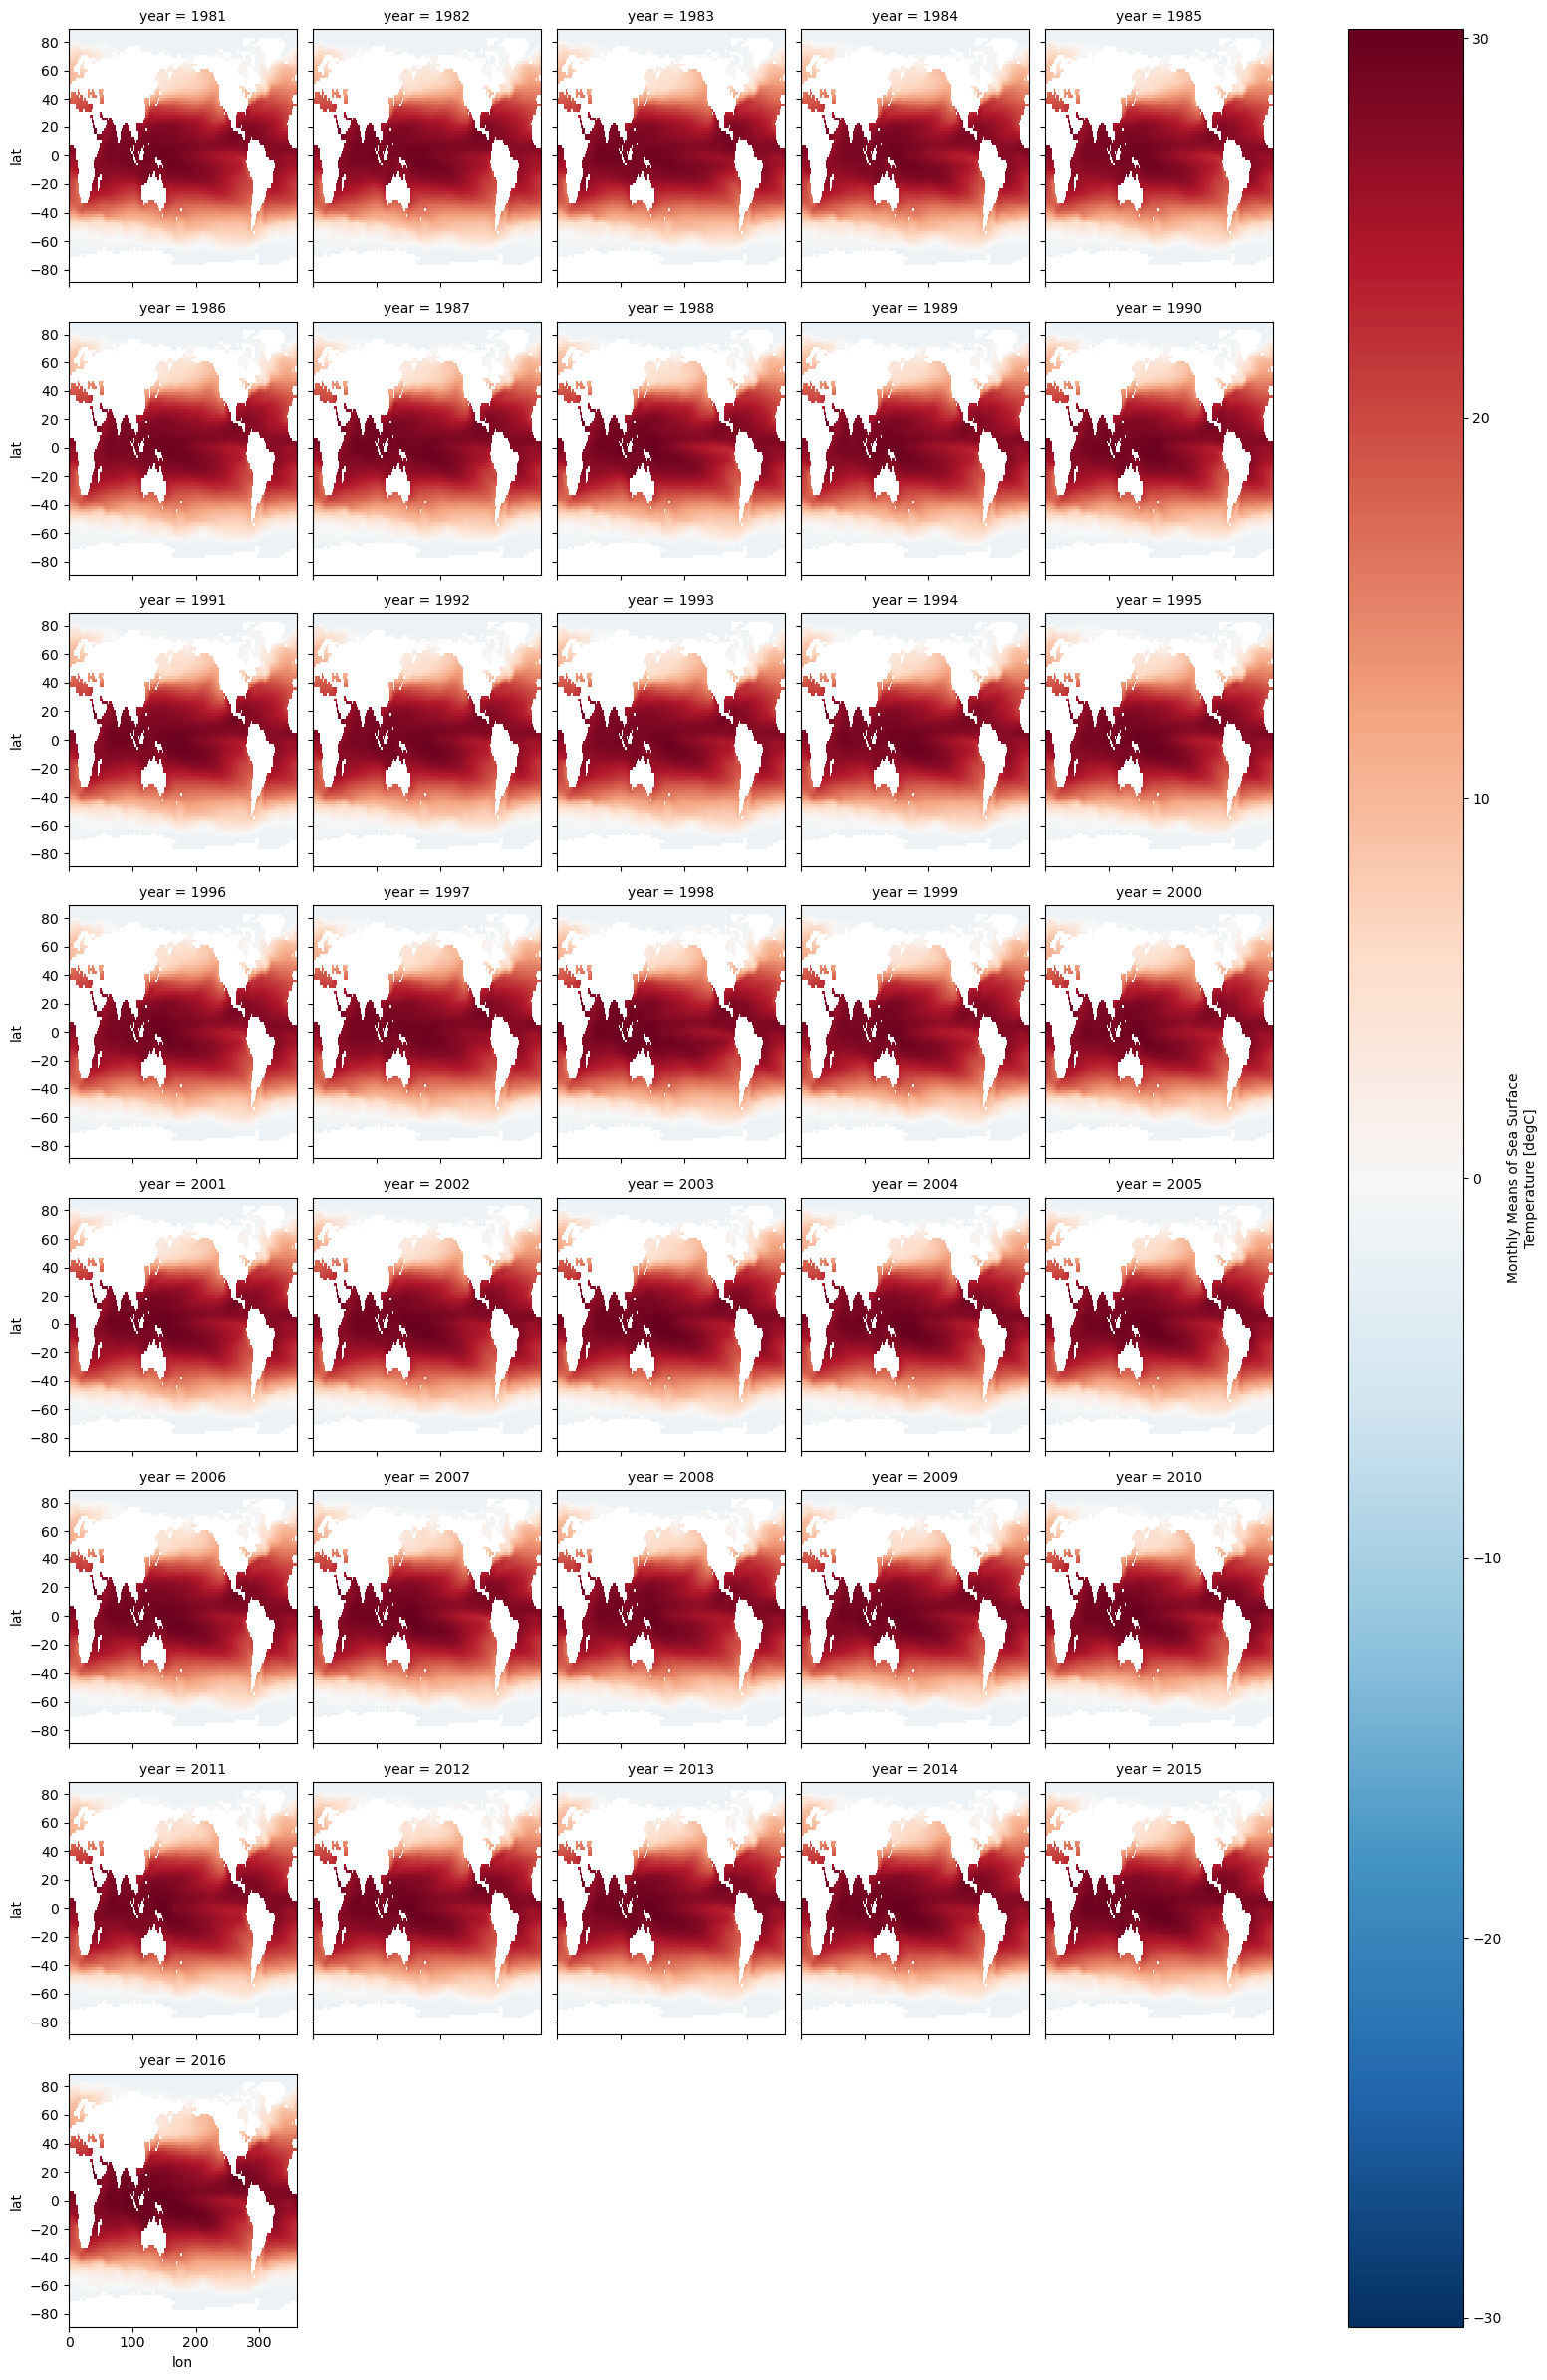

In [80]:
sst_yr_mean['sst'].plot(col='year', col_wrap = 5)

In [ ]:
climatology = sst_yr_mean.mean(dim='year')
climatology

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (nbnds) float64 9.969e+36 9.969e+36
    sst        (lat, lon) float32 -1.799 -1.799 -1.799 -1.799 ... nan nan nan

In [ ]:
px.imshow(climatology['sst'], x=lon, y=-lat)

In [60]:
anomaly = sst_yr_mean.groupby('year') - climatology
px.imshow(anomaly.mean(dim='year')['sst'], x=lon, y=-lat)

ValueError: incompatible dimensions for a grouped binary operation: the group variable 'year' is not a dimension on the other argument with dimensions Frozen({'lat': 89, 'lon': 180, 'nbnds': 2})

## Anomaly

In [46]:
sst_mn_mean_anomaly = xr.open_dataset('/Users/kris/GitHub/fall_2024_trp_proj/data/sst.mnmean.anomaly.nc')
#sst_mn_mean = sst_mn_mean.sel(year = slice('1990-01-01', '2021-12-01'))
#lat=sst_mn_mean['lat']
#lon=sst_mn_mean['lon']
sst_mn_mean_anomaly


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 528)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-12-01
    month    (time) int64 ...
Data variables:
    sst      (time, lat, lon) float32 ...